<a href="https://colab.research.google.com/github/sayanbanerjee32/keyword_search/blob/main/Smart_Search_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a super smart search engine over any free text data source

This code acompanies the following blog posts by https://medium.com/@thejoshtaylor


In [14]:
%%capture
# To import kaggle datasets
!pip install --upgrade pip 
!pip install kaggle==1.5.6

In [15]:
# import colab libraries
from google.colab import files
# import kaggle json to connect to kaggle user account to download datsets
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saansd2003","key":"49c2be11dfd314e10999ff432e1eeb65"}'}

In [16]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [17]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
# download our dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p 'datasets'

 39% 10.0M/25.7M [00:00<00:00, 27.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 56.2MB/s]


In [19]:
#unzip
!unzip datasets/imdb-dataset-of-50k-movie-reviews.zip -d datasets/

Archive:  datasets/imdb-dataset-of-50k-movie-reviews.zip
  inflating: datasets/IMDB Dataset.csv  


In [1]:
%%capture
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import nmslib
import time
from google.colab import drive
!pip install clean-text[gpl]
from cleantext import clean
import re

# drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


### Load data and create DF

In [21]:
import pandas as pd
df = pd.read_csv('datasets/IMDB Dataset.csv')
df.shape


(50000, 2)

In [23]:
df.head(1)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive


### Preprocess and tokenise

In [34]:
def fix_text(txt):
    txt = re.sub(r'(<br />)+','<LINEBREAK>',txt)
    return clean(txt,
                fix_unicode=True,               # fix various unicode errors
                to_ascii=True,                  # transliterate to closest ASCII representation
                lower=True,                     # lowercase text
                no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                no_urls=False,                  # replace all URLs with a special token
                no_emails=True,                # replace all email addresses with a special token
                no_phone_numbers=True,         # replace all phone numbers with a special token
                no_numbers=True,               # replace all numbers with a special token
                no_digits=False,                # replace all digits with a special token
                no_currency_symbols=True,      # replace all currency symbols with a special token
                no_punct=True,                 # remove punctuations
                replace_with_punct="<PUNCT>",          # instead of removing punctuations you may replace them
                replace_with_url="<URL>",
                replace_with_email="<EMAIL>",
                replace_with_phone_number="<PHONE>",
                replace_with_number="<NUMBER>",
                replace_with_digit="0",
                replace_with_currency_symbol="<CUR>",
                lang="en"                       # set to 'de' for German special handling
            )

In [24]:
nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus
text = df.review.str.lower().values


In [35]:
[fix_text(str(i)) for i in text[:10]]

['one of the other reviewers has mentioned that after watching just <number> oz episode you<punct>ll be hooked<punct> they are right<punct> as this is exactly what happened with me<punct><linebreak>the first thing that struck me about oz was its brutality and unflinching scenes of violence<punct> which set in right from the word go<punct> trust me<punct> this is not a show for the faint hearted or timid<punct> this show pulls no punches with regards to drugs<punct> sex or violence<punct> its is hardcore<punct> in the classic use of the word<punct><linebreak>it is called oz as that is the nickname given to the oswald maximum security state penitentary<punct> it focuses mainly on emerald city<punct> an experimental section of the prison where all the cells have glass fronts and face inwards<punct> so privacy is not high on the agenda<punct> em city is home to many<punct><punct>aryans<punct> muslims<punct> gangstas<punct> latinos<punct> christians<punct> italians<punct> irish and more<pun

In [36]:
text = [fix_text(str(i)) for i in text]
# text = [str(i) for i in text]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)


50000it [01:07, 741.47it/s]


### Fast text

In [45]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

KeyboardInterrupt: ignored

### Load fasttext and query

In [38]:
ft_model = FastText.load('_fasttext.model')

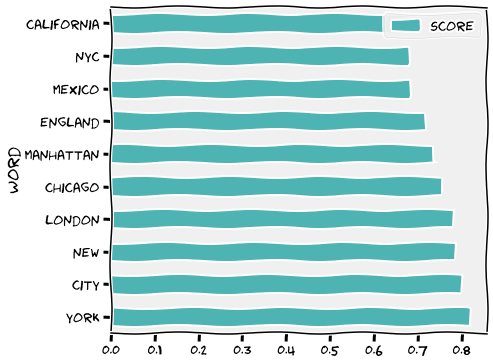

In [39]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("yorkshire", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

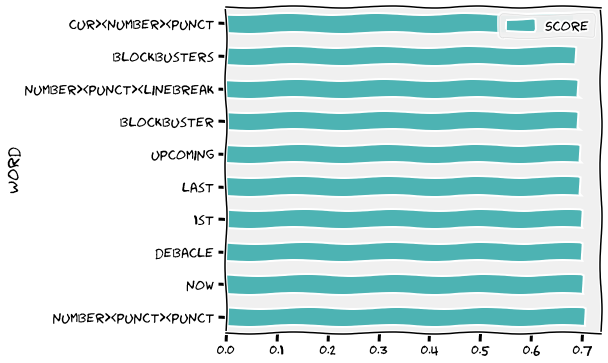

In [40]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("rg9", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

### Creating BM25 document vectors:

In [41]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []
unknown_words = []
embed_vocab = list(ft_model.wv.vocab.keys())
for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    if word in embed_vocab:
        vector = ft_model[word]
        weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
        / 
        (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
        weighted_vector = vector * weight
        doc_vector.append(weighted_vector)
    else: unknown_words.append(word)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)
  len(unknown_words)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
50000it [10:31, 79.12it/s]


In [42]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

### Load document vectors, build index and search:

In [43]:
with open( "weighted_doc_vects.p", "rb" ) as f:
    weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [46]:
# querying the index:
input = 'Movies fron Arthur Schnitzler'


input = fix_text(input).lower().split()

query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.review.values[i])

Searched 50000 records in 0.0012 seconds 

0.55
Who the hell rests at night whilst walking in the desert and travels in the heat of the sun, and these people are supposed to be professional trackers/journeymen!! Who the hell rests at night whilst walking in the desert and travels in the heat of the sun, and these people are supposed to be professional trackers/journeymen!! Who the hell rests at night whilst walking in the desert and travels in the heat of the sun, and these people are supposed to be professional trackers/journeymen!! Who the hell rests at night whilst walking in the desert and travels in the heat of the sun, and these people are supposed to be professional trackers/journeymen!! Who the hell rests at night whilst walking in the desert and travels in the heat of the sun, and these people are supposed to be professional trackers/journeymen!!
0.55
A real classic. A shipload of sailors trying to get to the towns daughters while their fathers go to extremes to deter the sail

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
